In [ ]:
from google.colab import drive
drive.mount("/content/myDrive")

Mounted at /content/myDrive


In [ ]:
import numpy as np
import scipy.sparse as sp
import torch
import pandas as pd
import os
import seaborn as sns

In [ ]:
def encode_onehot(labels):
    classes = set(labels)
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in
                    enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)),
                             dtype=np.int32)
    return labels_onehot

def normalize(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx

def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

def load_data(path, dataset="cora"):
    """Load citation network dataset (cora only for now)"""
    print('Loading {} dataset...'.format(dataset))

    idx_features_labels = np.genfromtxt("{}{}.content".format(path, dataset),
                                        dtype=np.dtype(str))
    features = sp.csr_matrix(idx_features_labels[:, 1:-1], dtype=np.float32) 
    labels = encode_onehot(idx_features_labels[:, -1]) 

    # build graph
    idx = np.array(idx_features_labels[:, 0], dtype=np.int32)
    idx_map = {j: i for i, j in enumerate(idx)}
    edges_unordered = np.genfromtxt("{}{}.cites".format(path, dataset),
                                    dtype=np.int32)
    edges = np.array(list(map(idx_map.get, edges_unordered.flatten())),
                     dtype=np.int32).reshape(edges_unordered.shape)
    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                        shape=(labels.shape[0], labels.shape[0]),
                        dtype=np.float32)

    # build symmetric adjacency matrix
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    features = normalize(features)
    adj = normalize(adj + sp.eye(adj.shape[0]))

    idx_train = range(140)
    idx_val = range(200, 500)
    idx_test = range(500, 1500)

    features = torch.FloatTensor(np.array(features.todense()))
    labels = torch.LongTensor(np.where(labels)[1])
    adj = sparse_mx_to_torch_sparse_tensor(adj)

    idx_train = torch.LongTensor(idx_train)
    idx_val = torch.LongTensor(idx_val)
    idx_test = torch.LongTensor(idx_test)

    return adj, features, labels, idx_train, idx_val, idx_test

path = "/content/myDrive/MyDrive/UROP/GCN/cora/"
adj, features, labels, idx_train, idx_val, idx_test=load_data(path= path, dataset="cora")

Loading cora dataset...


- **인접 행렬**
    - sparse 행렬(서로서로 연결된 비율이 매우 낮음)
    - 약 13,264개가 Not nonzero, 행렬의 사이즈는 2,709 X 2,709이다.
    - 약 0.18퍼센트만이 데이터에 값이 있음

In [ ]:
print(adj)

tensor(indices=tensor([[   0,    8,   14,  ..., 1389, 2344, 2707],
                       [   0,    0,    0,  ..., 2707, 2707, 2707]]),
       values=tensor([0.1667, 0.1667, 0.0500,  ..., 0.2000, 0.5000, 0.2500]),
       size=(2708, 2708), nnz=13264, layout=torch.sparse_coo)


- 특징 벡터
    - 각 노드에 해당하는 워드가 임베딩 되어 벡터 형태로 저장

In [ ]:
df_features=pd.DataFrame(features.numpy())
df_features

,0,1,2,3,4,5,6,7,8,9,...,1423,1424,1425,1426,1427,1428,1429,1430,1431,1432
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.05,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.058824,0.00,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2703,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0
2704,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0
2705,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0
2706,0.0,0.0,0.0,0.0,0.052632,0.0,0.0,0.0,0.0,0.0,...,0.052632,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
data_dir = os.path.expanduser(path)

In [ ]:
feature_names = ["w_{}".format(ii) for ii in range(1433)]
column_names =  feature_names + ["subject"]
node_data = pd.read_csv(os.path.join(data_dir, "cora.content"), sep='\t', header=None, names=column_names)

In [ ]:
node_data.head(20)

,w_0,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,...,w_1424,w_1425,w_1426,w_1427,w_1428,w_1429,w_1430,w_1431,w_1432,subject
31336,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1061127,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
1106406,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
13195,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
37879,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods
1126012,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Probabilistic_Methods
1107140,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Theory
1102850,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Neural_Networks
31349,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Neural_Networks
1106418,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Theory


- 레이블
    - 7개의 레이블을 클래스 번호로 레이블링(카테고리화)

In [ ]:
df_labels = pd.DataFrame(labels.numpy())
df_labels

,0
0,5
1,4
2,0
3,0
4,1
...,...
2703,2
2704,2
2705,2
2706,3


- 학습 데이터
    - 0 ~ 139(140)개 데이터를 사용

In [ ]:
df_idx_train=pd.DataFrame(idx_train.numpy())
df_idx_train

,0
0,0
1,1
2,2
3,3
4,4
...,...
135,135
136,136
137,137
138,138


- 검증 데이터
    - 200 ~ 499(300)개 데이터를 사용

In [ ]:
df_idx_val=pd.DataFrame(idx_val.numpy())
df_idx_val

,0
0,200
1,201
2,202
3,203
4,204
...,...
295,495
296,496
297,497
298,498


- 테스트 데이터
    - 500 ~ 1400(1000)개를 사용

In [ ]:
df_idx_test=pd.DataFrame(idx_test.numpy())
df_idx_test

,0
0,500
1,501
2,502
3,503
4,504
...,...
995,1495
996,1496
997,1497
998,1498


# 모델 정의

In [ ]:
from torch import nn
from torch.nn.parameter import Parameter
import torch
import torch.nn.functional as F
import math
 
class GraphConvolution(nn.Module):
    def __init__(self, feature_numbers, out_numbers, bias=False) -> None:
        super().__init__()
        self.bias = bias
        self.w = Parameter(torch.FloatTensor(feature_numbers, out_numbers))
        if bias:
            self.b = Parameter(torch.FloatTensor(out_numbers))
        self.reset_parameters()
        
    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.w.size(1))
        self.w.data.uniform_(-stdv, stdv)
        if self.bias is not False:
            self.b.data.uniform_(-stdv, stdv)
            
    def forward(self, x, adj):
		#-- input data 
		#-- X = 특징 행렬
		#-- adj = 인접 행렬(sparse matrix)
        support = torch.mm(x, self.w)
        out = torch.spmm(adj, support)
		#-- spmm(sparse mulple : sparse행렬 연산시 적은 메모리 사용 효율적으로 처리)
        if self.bias:
            out = out + self.b

        return out

class NodeClassificationGCNN(nn.Module):

    def __init__(self, feature_num, node_representation_dim, nclass, droupout=0.2, bias=False) -> None:
        super().__init__()
#-- 특징 행렬의 Column, Demention(CNN에서의 채널 수), output_dim
        self.gconv1 = GraphConvolution(feature_num, node_representation_dim, bias)
#-- 이전 레이어에서 나온 output, 최종 output class(7)
        self.gconv2 = GraphConvolution(node_representation_dim, nclass, bias)
        self.dropout = droupout

    def forward(self, x, adj):
        x = F.relu(self.gconv1(x, adj))
        x = F.dropout(x, self.dropout, self.training)
        x = F.relu(self.gconv2(x, adj))
        return F.log_softmax(x, dim=1)
#-- softmax -> 0~ 1사이에 값이 나옴        
#-- log를 이용하여 -무한대 값을 출력 가능


model = NodeClassificationGCNN(features.shape[1], 256, np.max(labels.detach().numpy())+1)

In [ ]:
def accuracy(out,label):
    oneHotCodded = out.max(1)[1].type_as(label)
    return oneHotCodded.eq(label).double().sum()/len(label)

In [ ]:
import torch.optim as optim
import torch.nn.functional as F

epochs=100
optimizer = optim.Adam(model.parameters(),lr=0.01)
train_losses=[]
val_losses=[]
train_accuracy=[]
val_accuracy=[]
for epoch in range(epochs):
    model.train()
    train_labels=labels[idx_train]
    val_labels=labels[idx_val]
    
    
    optimizer.zero_grad()
    output = model(features, adj)
    train_loss=F.nll_loss(output[idx_train],train_labels)
    train_losses.append(train_loss)
    t_a=accuracy(output[idx_train],train_labels)
    train_accuracy.append(t_a)
    print(f"Training epoch {epoch} ; accuracy: {accuracy(output[idx_train],train_labels)}; loss: {train_loss.item()}")
    train_loss.backward()
    optimizer.step()
    
    model.eval()
    output = model(features, adj)
    val_loss=F.nll_loss(output[idx_val],val_labels)
    val_losses.append(val_loss)
    v_a=accuracy(output[idx_val],val_labels)
    val_accuracy.append(v_a)
    print(f"Validation epoch {epoch} ; accuracy: {accuracy(output[idx_val],val_labels)}; loss: {val_loss.item()}")
    

Training epoch 0 ; accuracy: 0.1; loss: 1.9465303421020508
Validation epoch 0 ; accuracy: 0.58; loss: 1.8982595205307007
Training epoch 1 ; accuracy: 0.6714285714285714; loss: 1.8859455585479736
Validation epoch 1 ; accuracy: 0.6333333333333333; loss: 1.832379937171936
Training epoch 2 ; accuracy: 0.7571428571428571; loss: 1.805920958518982
Validation epoch 2 ; accuracy: 0.6833333333333333; loss: 1.7520359754562378
Training epoch 3 ; accuracy: 0.8142857142857143; loss: 1.704148769378662
Validation epoch 3 ; accuracy: 0.74; loss: 1.6673837900161743
Training epoch 4 ; accuracy: 0.85; loss: 1.5927574634552002
Validation epoch 4 ; accuracy: 0.7666666666666667; loss: 1.5786938667297363
Training epoch 5 ; accuracy: 0.8785714285714286; loss: 1.4743601083755493
Validation epoch 5 ; accuracy: 0.77; loss: 1.486070156097412
Training epoch 6 ; accuracy: 0.8857142857142857; loss: 1.3521419763565063
Validation epoch 6 ; accuracy: 0.7766666666666666; loss: 1.391239881515503
Training epoch 7 ; accurac

<Axes: >

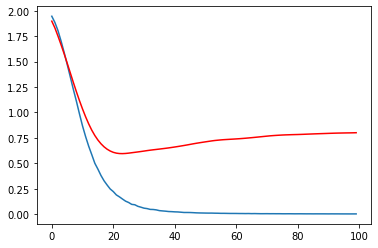

In [ ]:
train_losses_float=[float(train_loss.cpu().detach().numpy()) for train_loss in train_losses]
train_loss_indices=[i for i, l in enumerate(train_losses_float)]
plt = sns.lineplot(x=train_loss_indices, y=train_losses_float)
val_losses_float=[float(val_loss.cpu().detach().numpy()) for val_loss in val_losses]
val_loss_indices=[i for i, l in enumerate(val_losses_float)]
plt = sns.lineplot(x=val_loss_indices, y=val_losses_float, color='r')
plt

In [ ]:
t_a = t_a.cpu().detach().numpy()
v_a = v_a.cpu().detach().numpy()

AttributeError: ignored

<Axes: >

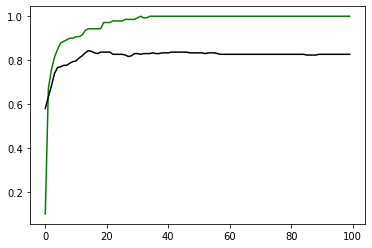

In [ ]:
train_accuracy_float=[float(t_a.cpu().detach().numpy()) for t_a in train_accuracy]
t_a_indices=[i for i, l in enumerate(train_accuracy_float)]
plt = sns.lineplot(x=t_a_indices, y=train_accuracy_float,color='green')

val_accuracy_float=[float(v_a.cpu().detach().numpy()) for v_a in val_accuracy]
v_a_indices=[i for i, l in enumerate(val_accuracy_float)]
plt = sns.lineplot(x=v_a_indices, y=val_accuracy_float, color='black')
plt

In [ ]:
test_losses=[]
model.eval()
test_labels=labels[idx_test]
output = model(features, adj)
loss=F.nll_loss(output[idx_test],test_labels)
test_losses.append(loss)
print(f"Test set ; accuracy: {accuracy(output[idx_test],test_labels)}; loss: {loss.item()}")

Test set ; accuracy: 0.804; loss: 0.6483832001686096


torch.Size([2708, 7])


<Axes: >

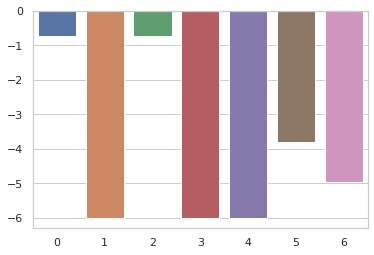

In [ ]:
import seaborn as sns
import numpy as np
sample = 500
sns.set_theme(style="whitegrid")
print(model(features, adj).shape)
pred = model(features, adj)
sns.barplot(x=np.array(range(7)), y=pred[sample].detach().cpu().numpy())

In [ ]:
output_idx_test=output[idx_test]

- 결과 확인
output_idx 와 실제 label값이 같은지 확인
- 컬럼의 -값이 가장 큰 값이 정답임 
ex) 0번 컬럼의 가장 큰 값은 2번이고 실제 값을 확인해보면 2로 동일
4번 컬럼의 가장 큰 값은 0번이지만 실제값은 5로 틀린 예측을 확인

In [ ]:
df_output_idx_test=pd.DataFrame(output_idx_test.detach().numpy())
df_output_idx_test

,0,1,2,3,4,5,6
0,-0.725212,-6.005728,-0.736229,-6.005728,-6.005728,-3.792011,-4.973632
1,-3.817583,-5.164100,-3.851151,-5.690371,-5.268350,-0.063756,-5.453607
2,-0.020370,-7.727784,-8.191612,-8.191612,-8.191612,-4.019109,-6.987180
3,-5.272512,-5.867709,-4.009189,-6.345364,-6.131048,-0.032050,-6.499608
4,-0.060730,-6.206880,-4.229628,-5.762163,-5.742166,-4.214129,-3.853199
...,...,...,...,...,...,...,...
995,-3.398221,-5.021758,-0.139514,-4.905099,-4.767734,-2.771209,-4.448250
996,-11.245489,-10.489838,-10.801853,-0.000206,-9.042240,-11.245489,-11.245489
997,-5.400803,-6.735282,-6.136186,-0.017724,-4.994536,-6.444426,-6.615763
998,-2.375526,-3.378087,-3.230198,-0.733360,-1.178428,-3.547206,-4.103642


In [ ]:
df_test_labels=pd.DataFrame(test_labels.numpy())
print(type(df_test_labels))
df_test_labels.T

<class 'pandas.core.frame.DataFrame'>


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0,5,0,5,5,5,0,6,6,4,...,5,6,6,5,5,2,3,3,3,5
